In [1]:
import numpy as np
import cv2
import torch
import dataloader
import matplotlib.pyplot as plt
import torchvision
import os
from tqdm import tqdm
import metrics
from collections import defaultdict
from scipy.stats import binned_statistic
import utilities

from code.quadratic.interpolate import interpolate as qvi_interpolate

In [2]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [12]:
# get test frame sequence
ds = dataloader.adobe240_dataset(quadratic=True)

In [13]:
X, y = ds[120]

In [39]:
video = np.stack((X[0], X[1], y, X[2], X[3]))
video = video.astype(np.uint8)
video.shape

(5, 720, 1280, 3)

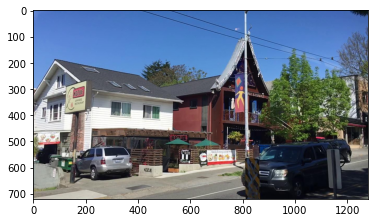

In [40]:
plt.imshow(video[0])

In [42]:
# find features in first frame
old_gray = cv2.cvtColor(video[0], cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

In [43]:
p0.shape

(100, 1, 2)

In [44]:
# compute optical flow (old frame, new frame, features)
new_gray = cv2.cvtColor(video[4], cv2.COLOR_BGR2GRAY)

# calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)

In [50]:
good_new = p1[st==1]
good_old = p0[st==1]

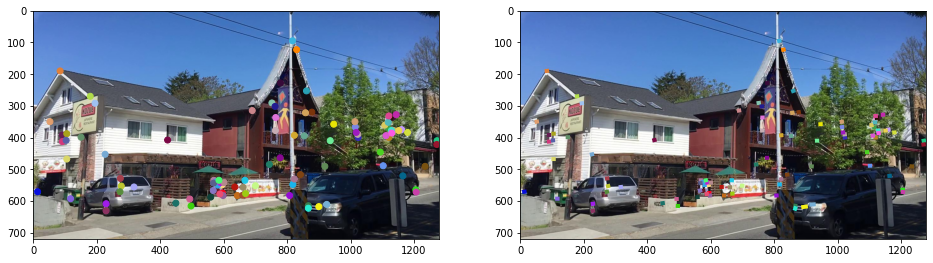

In [123]:
# plot old + features, plot new + features + lines between
f, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

colors = np.random.randint(0,255,(100,3)) / 255

ax1.imshow(video[0])
ax1.scatter(good_old[:,0], good_old[:,1], color=colors)


ax2.imshow(video[4])
# ax2.scatter(good_new[:,0], good_new[:,1], color=colors)

for i in range(100):
    ax2.plot([good_old[i,0], good_new[i,0]], [good_old[i,1], good_new[i,1]], color=colors[i], linewidth=4)

In [3]:
def compute_displacement(x1, x2):
    '''
    computes max displacement batch-wise
    '''
    
    assert x1.shape == x2.shape
    
    B = x1.size(0)
    mean_disp = []
    max_disp = []
    median_disp = []
    b_displacements = []
    
    for b in range(B):
        f1 = x1[b].numpy().astype(np.uint8)
        f2 = x2[b].numpy().astype(np.uint8)
        
        old_gray = cv2.cvtColor(f1, cv2.COLOR_BGR2GRAY)
        new_gray = cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY)
        p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
        
        # compute optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)
        
        
        good_new = p1[st==1]
        good_old = p0[st==1]
        
        displacements = np.sqrt(np.sum((good_new - good_old)**2, axis=1))
        
        mean_disp.append(np.mean(displacements))
        max_disp.append(np.max(displacements))
        median_disp.append(np.median(displacements))
        b_displacements.extend(displacements)
        
    return mean_disp, median_disp, max_disp, displacements
        
        

In [9]:
ds = dataloader.adobe240_dataset()

n_train = int(len(ds) * 0.8)
n_valid = len(ds) - n_train


_, valid = torch.utils.data.random_split(ds, [n_train, n_valid])
dl = torch.utils.data.DataLoader(valid, batch_size=2)

# eval test set
results_sepconv = defaultdict(list)
# init summarywriter

# load model
G = utilities.get_sepconv(input_size=2)
G = G.cuda()
G = G.eval()



with torch.no_grad():
    for X, y in tqdm(dl, total=len(dl)):
        
        # compute displacements
        mean_disp, median_disp, max_disp, _ = compute_displacement(X[:,0], y)
        
        results_sepconv['mean_disp'].extend(mean_disp)
        results_sepconv['max_disp'].extend(max_disp)
        results_sepconv['median_disp'].extend(median_disp)
        
        
        
        X = X.permute(0,1,4,2,3).cuda() / 255
        x2 = x2.permute(0,3,1,2).cuda() / 255
        y = y.permute(0,3,1,2).cuda()

        y_hat = G(X).mul(255).clamp(0,255).int()

        psnr = metrics.psnr(y_hat, y)
        ie = metrics.interpolation_error(y_hat, y)
        
        results_sepconv['psnr'].extend(psnr)
        results_sepconv['ie'].extend(ie)


100%|██████████████████████████████████████████████████████████████████████████████| 1198/1198 [12:26<00:00,  1.60it/s]


In [5]:
ds = dataloader.adobe240_dataset()

n_train = int(len(ds) * 0.8)
n_valid = len(ds) - n_train


_, valid = torch.utils.data.random_split(ds, [n_train, n_valid])
dl = torch.utils.data.DataLoader(valid, batch_size=1)

# eval test set
results_qvilin = defaultdict(list)
# init summarywriter

# load model

with torch.no_grad():
    for X, y in tqdm(dl, total=len(dl)):
        
        x1, x2 = torch.unbind(X, dim=1)
        
        # compute displacements
        mean_disp, median_disp, max_disp, _ = compute_displacement(x1, y)
        
        results_qvilin['mean_disp'].extend(mean_disp)
        results_qvilin['max_disp'].extend(max_disp)
        results_qvilin['median_disp'].extend(median_disp)
        
        
        
        
        x1 = x1.permute(0,3,1,2).cuda() / 255
        x2 = x2.permute(0,3,1,2).cuda() / 255
        y = y.permute(0,3,1,2).cuda()

        y_hat = qvi_interpolate([x1, x2]).mul(255).clamp(0,255).int()

        psnr = metrics.psnr(y_hat, y)
        ie = metrics.interpolation_error(y_hat, y)
        
        results_qvilin['psnr'].extend(psnr)
        results_qvilin['ie'].extend(ie)


100%|██████████████████████████████████████████████████████████████████████████████| 2395/2395 [26:20<00:00,  1.52it/s]


### QVI quadratic

In [6]:
ds = dataloader.adobe240_dataset(quadratic=True)

n_train = int(len(ds) * 0.8)
n_valid = len(ds) - n_train


_, valid = torch.utils.data.random_split(ds, [n_train, n_valid])
dl = torch.utils.data.DataLoader(valid, batch_size=1)

# eval test set
results_qviquad = defaultdict(list)
# init summarywriter

# load model

with torch.no_grad():
    for X, y in tqdm(dl, total=len(dl)):
        
        x1, x2, x4, x5 = torch.unbind(X, dim=1)
        
        # compute displacements
        mean_disp, median_disp, max_disp, _ = compute_displacement(x1, y)
        
        results_qviquad['mean_disp'].extend(mean_disp)
        results_qviquad['max_disp'].extend(max_disp)
        results_qviquad['median_disp'].extend(median_disp)
        
        
        
        
        x1 = x1.permute(0,3,1,2).cuda() / 255
        x2 = x2.permute(0,3,1,2).cuda() / 255
        x4 = x4.permute(0,3,1,2).cuda() / 255
        x5 = x5.permute(0,3,1,2).cuda() / 255
        y = y.permute(0,3,1,2).cuda()

        y_hat = qvi_interpolate([x1, x2, x4, x5]).mul(255).clamp(0,255).int()

        psnr = metrics.psnr(y_hat, y)
        ie = metrics.interpolation_error(y_hat, y)
        
        results_qviquad['psnr'].extend(psnr)
        results_qviquad['ie'].extend(ie)


100%|██████████████████████████████████████████████████████████████████████████████| 2395/2395 [35:09<00:00,  1.14it/s]


In [7]:
t_displacements = []
with torch.no_grad():
    for X, y in tqdm(dl, total=len(dl)):
        
        # compute displacements
        _, _, _, displacements = compute_displacement(X[:,0], y)
        
        t_displacements.extend(displacements)
        
    

100%|██████████████████████████████████████████████████████████████████████████████| 2395/2395 [05:00<00:00,  7.96it/s]


In [17]:
def get_stats(results):
    stats_mean, bin_edges, n = binned_statistic(results['mean_disp'], results['ie'], statistic='mean', bins=range(0,50,5))
    stats_lowb, bin_edges, n = binned_statistic(results['mean_disp'], results['ie'], statistic=lambda x: np.quantile(x, q=0.1), bins=range(0,50,5))
    stats_uppb, bin_edges, n = binned_statistic(results['mean_disp'], results['ie'], statistic=lambda x: np.quantile(x, q=0.9), bins=range(0,50,5))
    
    err_uppb = stats_uppb-stats_mean
    err_lowb = stats_mean-stats_lowb
    
    return stats_mean, err_uppb, err_lowb, bin_edges

In [67]:
# stats_mean, bin_edges, n = binned_statistic(results['mean_disp'], results['ie'], statistic='mean', bins=range(0,50,5))
# stats_lowb, bin_edges, n = binned_statistic(results['mean_disp'], results['ie'], statistic=lambda x: np.quantile(x, q=0.25), bins=range(0,50,5))
# stats_uppb, bin_edges, n = binned_statistic(results['mean_disp'], results['ie'], statistic=lambda x: np.quantile(x, q=0.75), bins=range(0,50,5))

In [18]:
stats_mean_sc, err_uppb_sc, err_lowb_sc, bin_edges_sc = get_stats(results_sepconv)
stats_mean_ql, err_uppb_ql, err_lowb_ql, bin_edges_ql = get_stats(results_qvilin)
stats_mean_qq, err_uppb_qq, err_lowb_qq, bin_edges_qq = get_stats(results_qviquad)

No handles with labels found to put in legend.


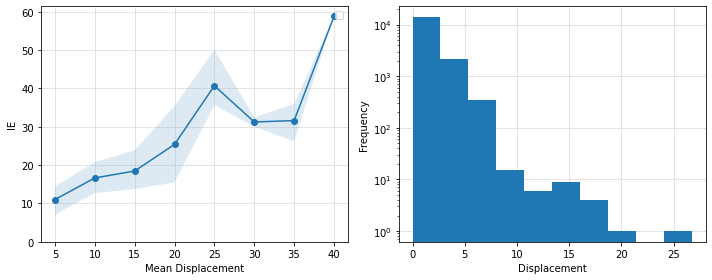

In [109]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))


ax1.plot(bin_edges_sc[1:], stats_mean_sc, marker='o')
ax1.fill_between(bin_edges_sc[1:], stats_lowb, stats_uppb, alpha=0.15)
ax1.grid(linewidth=0.5, linestyle='--')
ax1.set_ylabel('IE')
ax1.set_xlabel('Mean Displacement')
ax1.legend()
ax1.set_ylim(0)


ax2.grid(linewidth=0.5, linestyle='--')
ax2.hist(t_displacements, log=True, zorder=10)
ax2.set_xlabel('Displacement')
ax2.set_ylabel('Frequency')


plt.tight_layout()
plt.savefig('figures/error_vs_displacement.pdf', type='pdf', bbox_inches='tight')




In [90]:
# err_uppb = stats_uppb-stats_mean
# err_lowb = stats_mean-stats_lowb

# np.stack([err_uppb, err_lowb])

In [14]:
stats_mean_sc

array([10.98867988, 16.71134526, 17.33387232, 21.35973821, 32.30436103,
       19.98617649, 28.09092267, 25.91765022, 33.57460785])

In [16]:
err_lowb_sc

array([ 3.85794341,  4.55949551,  1.9783175 ,  5.87498127, 12.63231913,
        2.57287264,  4.26986917,  0.        ,  0.        ])

In [27]:
stats_mean_qq-err_lowb_qq

array([4.54827356, 4.5440383 , 3.70505819, 3.73870392, 6.43529558,
       9.44697008, 7.17698655, 6.87315521, 3.75513887])

In [30]:
err_uppb_ql

array([ 3.57578156,  4.40546117,  2.76488481, 23.78308134, 25.49176035,
        0.85158043,  0.14789429,  0.        ,  0.        ])

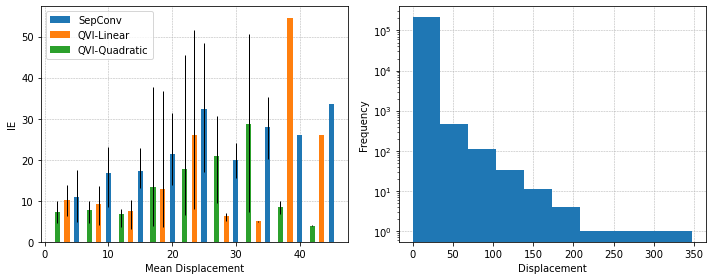

In [32]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))


ax1.bar(bin_edges_sc[1:], stats_mean_sc, yerr=np.stack([err_lowb_sc, err_uppb_sc]), error_kw={'linewidth':1, 'zorder':20}, zorder=10, label='SepConv')#, marker='o')
ax1.bar(bin_edges_ql[1:]-1.5, stats_mean_ql, yerr=np.stack([err_lowb_ql, err_uppb_ql]), error_kw={'linewidth':1, 'zorder':20}, zorder=10, label='QVI-Linear')
ax1.bar(bin_edges_qq[1:]-3, stats_mean_qq, yerr=np.stack([err_lowb_qq, err_uppb_qq]), error_kw={'linewidth':1, 'zorder':20}, zorder=10, label='QVI-Quadratic')


# ax1.fill_between(bin_edges[1:], stats_lowb, stats_uppb, alpha=0.15)
ax1.grid(linewidth=0.5, linestyle='--')
ax1.set_ylabel('IE')
ax1.set_xlabel('Mean Displacement')
ax1.legend()
# ax1.set_ylim(0)


ax2.grid(linewidth=0.5, linestyle='--', zorder=-1)
ax2.hist(t_displacements, log=True, zorder=10)
ax2.set_xlabel('Displacement')
ax2.set_ylabel('Frequency')


plt.tight_layout()
plt.savefig('figures/error_vs_displacement.pdf', type='pdf', bbox_inches='tight')


